### Possible Areas to Examine

+ *How does time of day affect an order?*
- *What types of items are reordered most often?*
- How many different cart sizes do there appear to be among buyers, and what meaningful differences exist in those baskets of goods?
- How does order affect when a user adds something to their cart?
- Note: This data set is quite large, and taking a random 10-percent sample (with justification) is acceptable.

- Build model that predicts size of cart based on products chosen?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from functools import partial
from sklearn import metrics

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
departments = pd.read_csv('departments.csv')
aisles = pd.read_csv('aisles.csv')

### Creating One Large DataFrame With All DataFrames Merged

In [3]:
df = pd.merge(products, departments, on='department_id')

In [4]:
df = pd.merge(df, order_products_prior, on='product_id')

In [5]:
df = pd.merge(df, aisles, on='aisle_id')

In [6]:
# df = pd.merge(df, order_products_train, on='product_id')

In [7]:
df = pd.merge(df, orders, on='order_id')
full_data = df

In [8]:
full_data.isnull().sum(axis=0)

product_id                      0
product_name                    0
aisle_id                        0
department_id                   0
department                      0
order_id                        0
add_to_cart_order               0
reordered                       0
aisle                           0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
dtype: int64

**No null values found in dataframe. This is good news**

### Analyzing Orders DataFrame

**How many unique orders and unique products are there?**

In [9]:
unique_orders = len(full_data['order_id'].unique())
unique_products = len(full_data['product_id'].unique())
print(f"Number of Unique Orders: {unique_orders}")
print(f"Number of Unique Products: {unique_products}")

Number of Unique Orders: 3214874
Number of Unique Products: 49677


**Orders DataFrame has labels 'Test', 'Train', and 'Prior'. These will be used for the model**

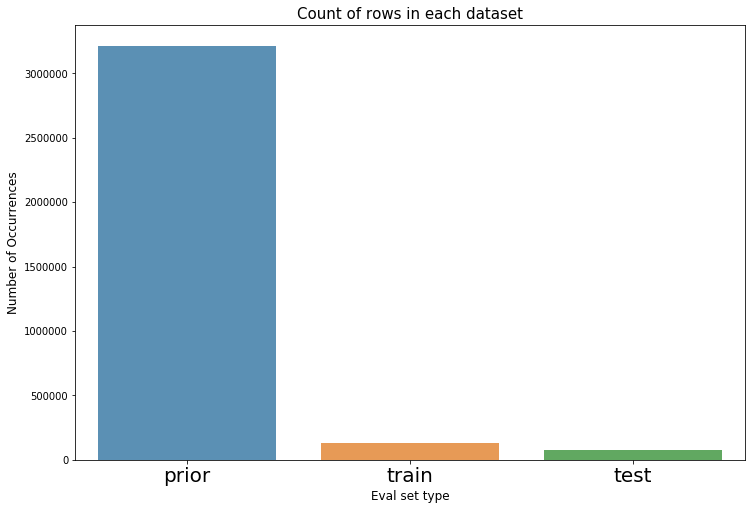

In [10]:
count_df = orders.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(count_df.index, count_df.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='horizontal', fontsize=20)
plt.show()

### This shows that we need to predict 75,000 orders

In [11]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

### Data page says we only have data for customer orders 4 to 100. We can check that by graphing the values. 

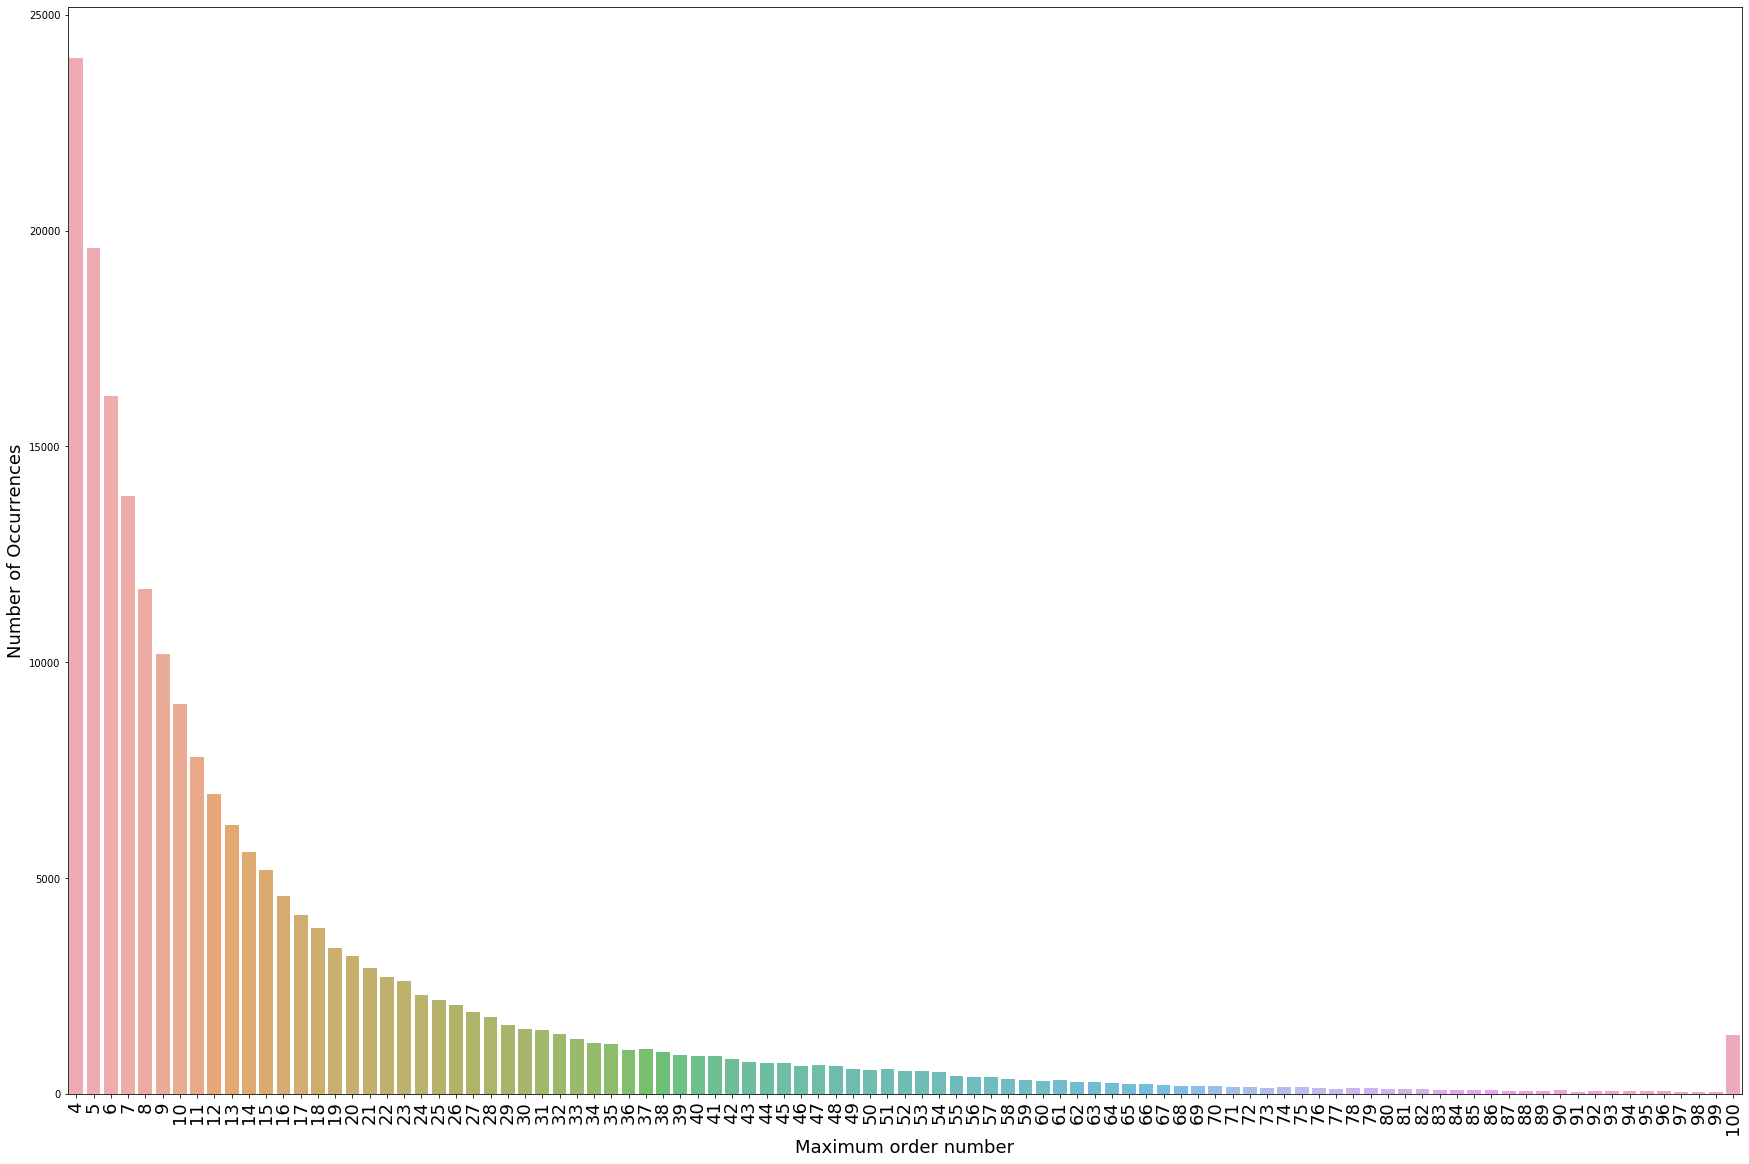

In [12]:
cnt_srs = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(30,20))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=18)
plt.xlabel('Maximum order number', fontsize=18)
plt.xticks(rotation='vertical', fontsize=18)
plt.show()

**We can also see that most customers ordered 4 orders**

### First Exploration: How does day of the week effect ordering?


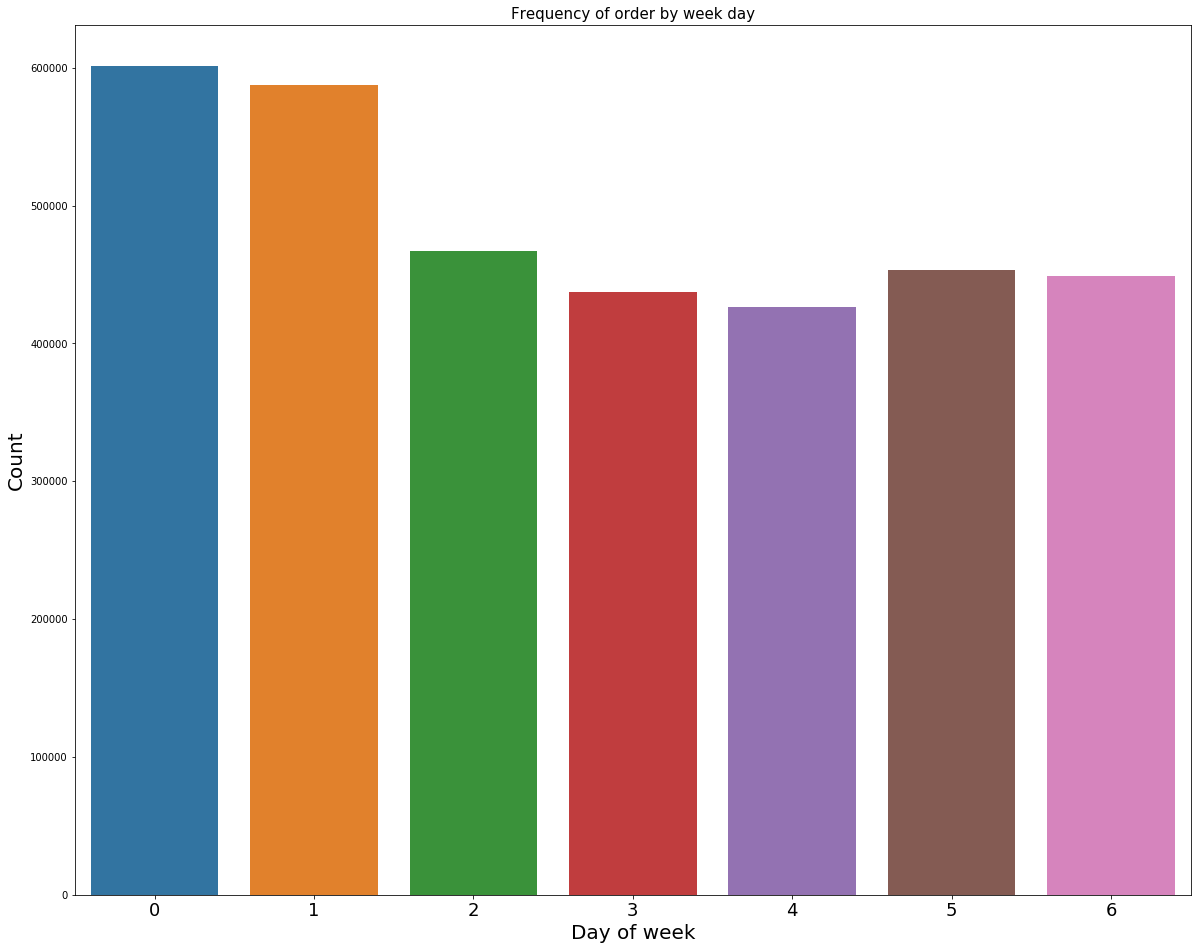

In [13]:
plt.figure(figsize=(20,16))
sns.countplot(x="order_dow", data=orders)
plt.ylabel('Count', fontsize=20)
plt.xlabel('Day of week', fontsize=20)
plt.xticks(rotation='horizontal', fontsize=18)
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

**According to the dictionary, 0 is Saturday. Therefore, Saturday and Sunday are the top shopping days, while Wednesday is the lowest.**

### Now we can see how the time of day effects ordering.


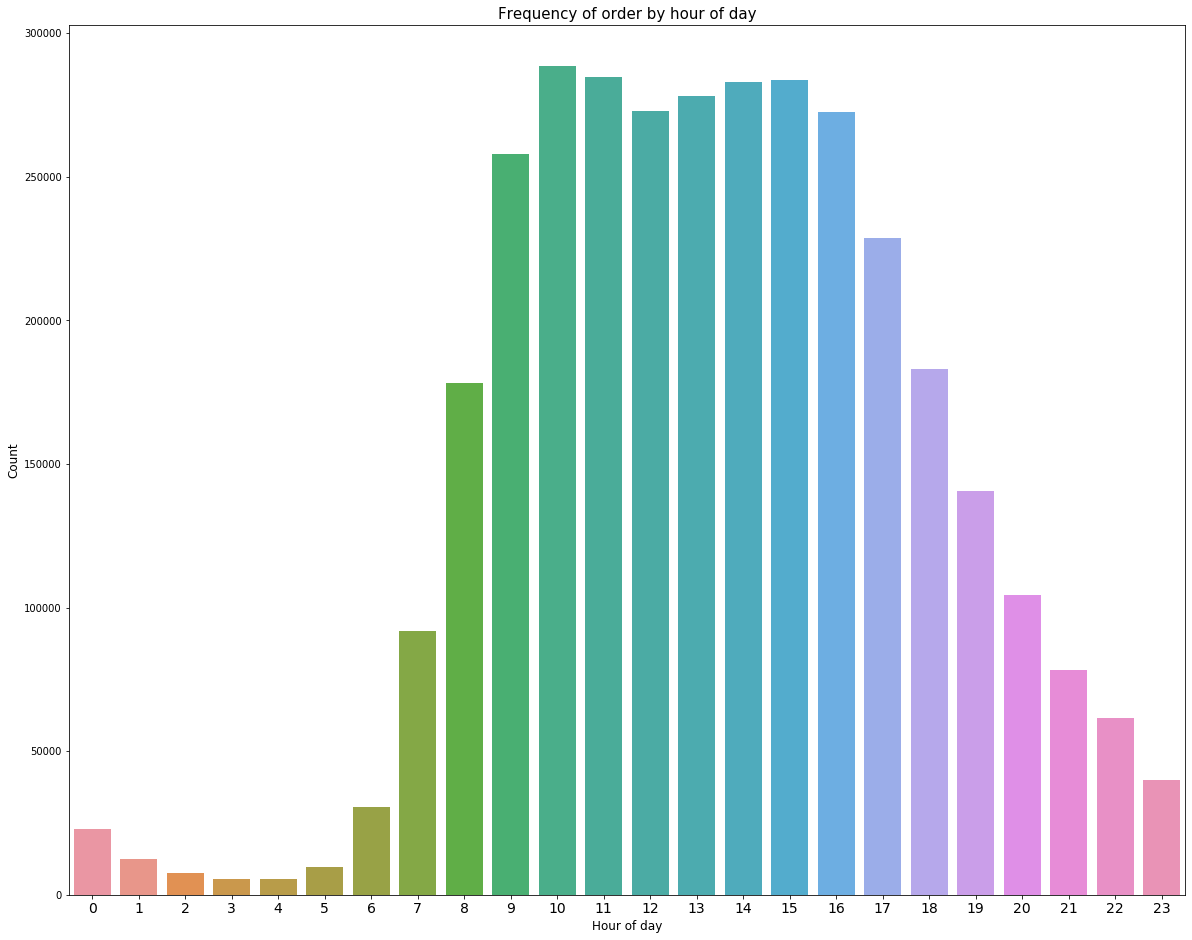

In [14]:
plt.figure(figsize=(20,16))
sns.countplot(x="order_hour_of_day", data=orders)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='horizontal', fontsize=14)
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

**Most shopping happens during the day, between the hours of 7am and 8pm.**

### We can combine the day of the week and the hour of the day to see that relationship

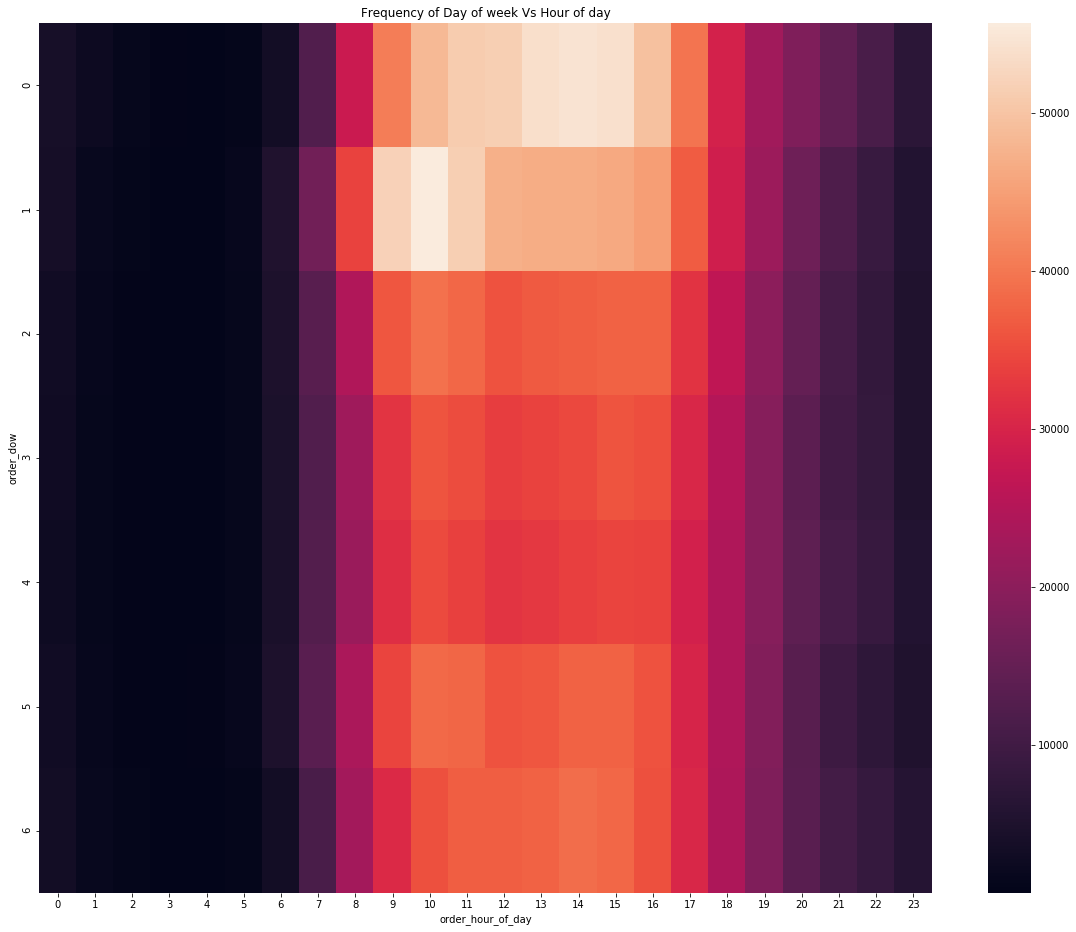

In [15]:
group_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
group_df = group_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(20,16))
sns.heatmap(group_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

**From this we can see that Saturday early afternoon and Sunday morning are the most frequent shopping times**

### To view the time interval between orders:

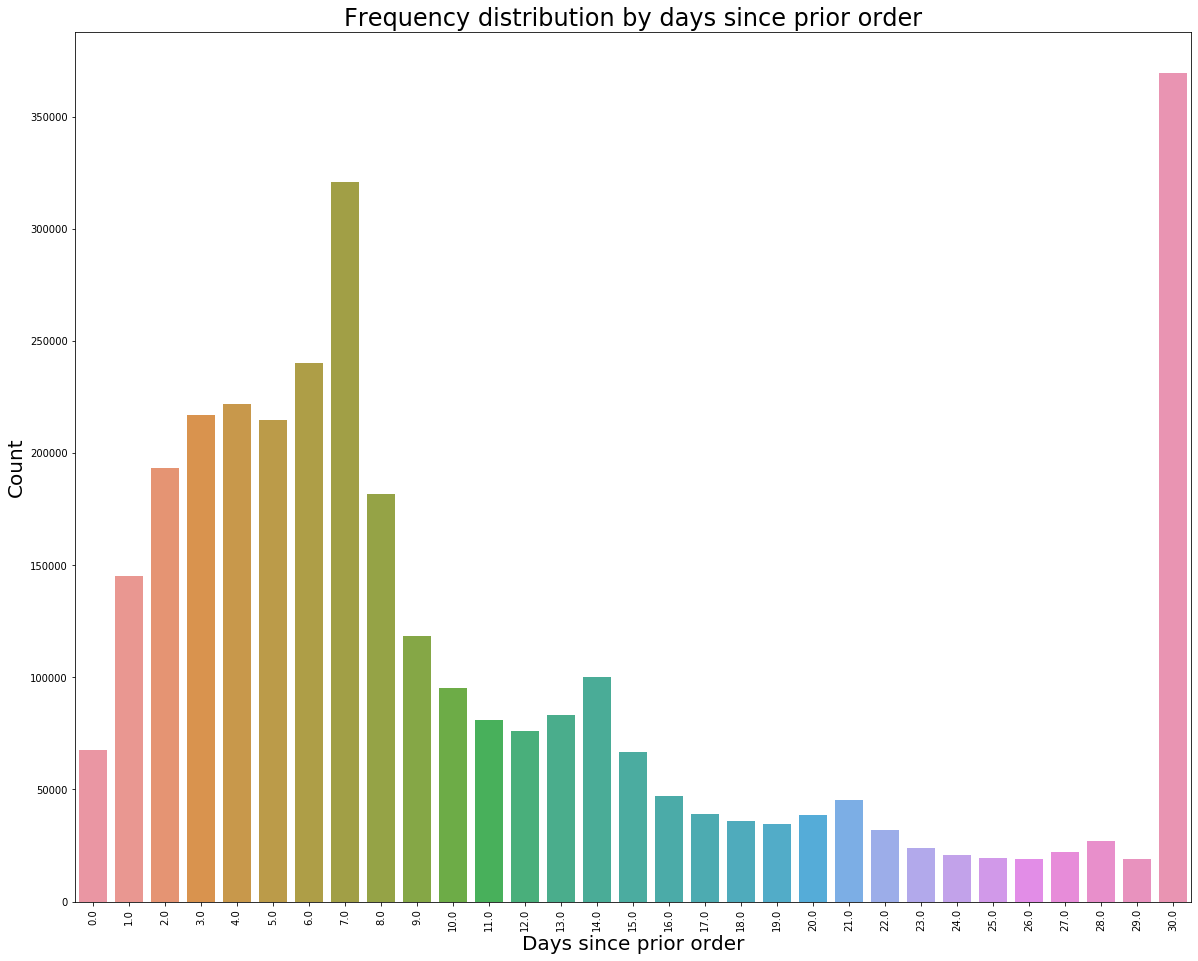

In [16]:
plt.figure(figsize=(20,16))
sns.countplot(x="days_since_prior_order", data=orders)
plt.ylabel('Count', fontsize=20)
plt.xlabel('Days since prior order', fontsize=20)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=24)
plt.show()

**Because there are peaks at 7 and 30, it shows most customers shop either once a week or once a month**

### What is the re-order percentage?

In [17]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


**The data says a reorder is a 1, so we can take the sum to determine how many reorders there were, divided by the number of orders total**

In [18]:
order_products_prior['reordered'].sum() / order_products_prior['reordered'].count()

0.5896974667922161

**For the train set, we can do the same thing**

In [19]:
order_products_train['reordered'].sum() / order_products_train['reordered'].count()

0.5985944127509629

**We can see that about 59% of products are reorders.**

### How many products did people usually order?

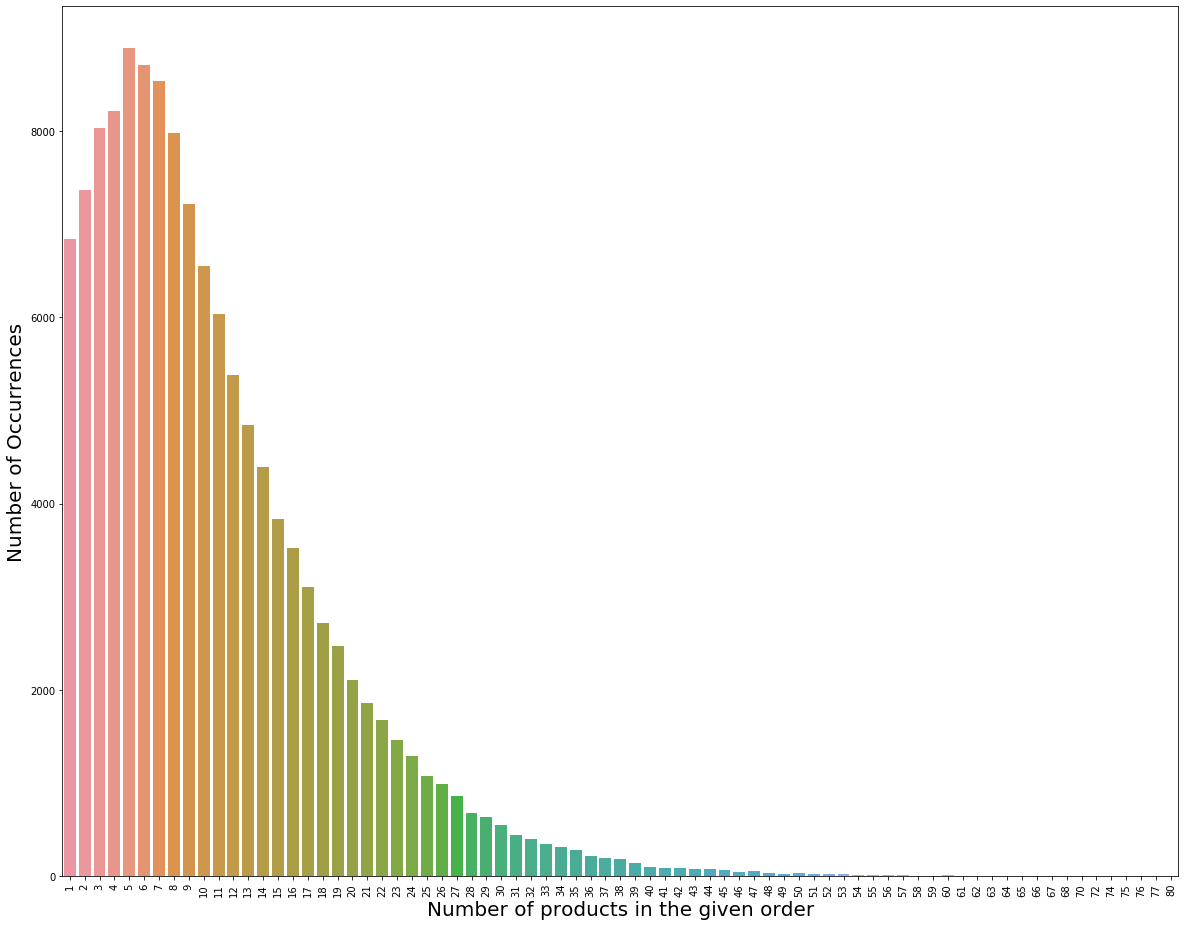

In [20]:
grouped = order_products_train.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
counts = grouped['add_to_cart_order'].value_counts()

plt.figure(figsize=(20,16))
sns.barplot(counts.index, counts.values)
plt.ylabel('Number of Occurrences', fontsize=20)
plt.xlabel('Number of products in the given order', fontsize=20)
plt.xticks(rotation='vertical')
plt.show()

**We can see that there is a peak at 5, so most people bought 5 products per order.** 

**Now we can see what those types of products are by looking at the dataframe after combining a few dataframes together**

In [21]:
order_products_prior = pd.merge(order_products_prior, products, on='product_id', how='left')
order_products_prior = pd.merge(order_products_prior, aisles, on='aisle_id', how='left')
order_products_prior = pd.merge(order_products_prior, departments, on='department_id', how='left')
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [22]:
count_df = order_products_prior['product_name'].value_counts().reset_index().head(20)
count_df.columns = ['product_name', 'frequency_count']
count_df.head()

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584


**Four of the top five products are organic produce**

### Let's look at those items more closely

Text(0.5, 0, 'Product Name')

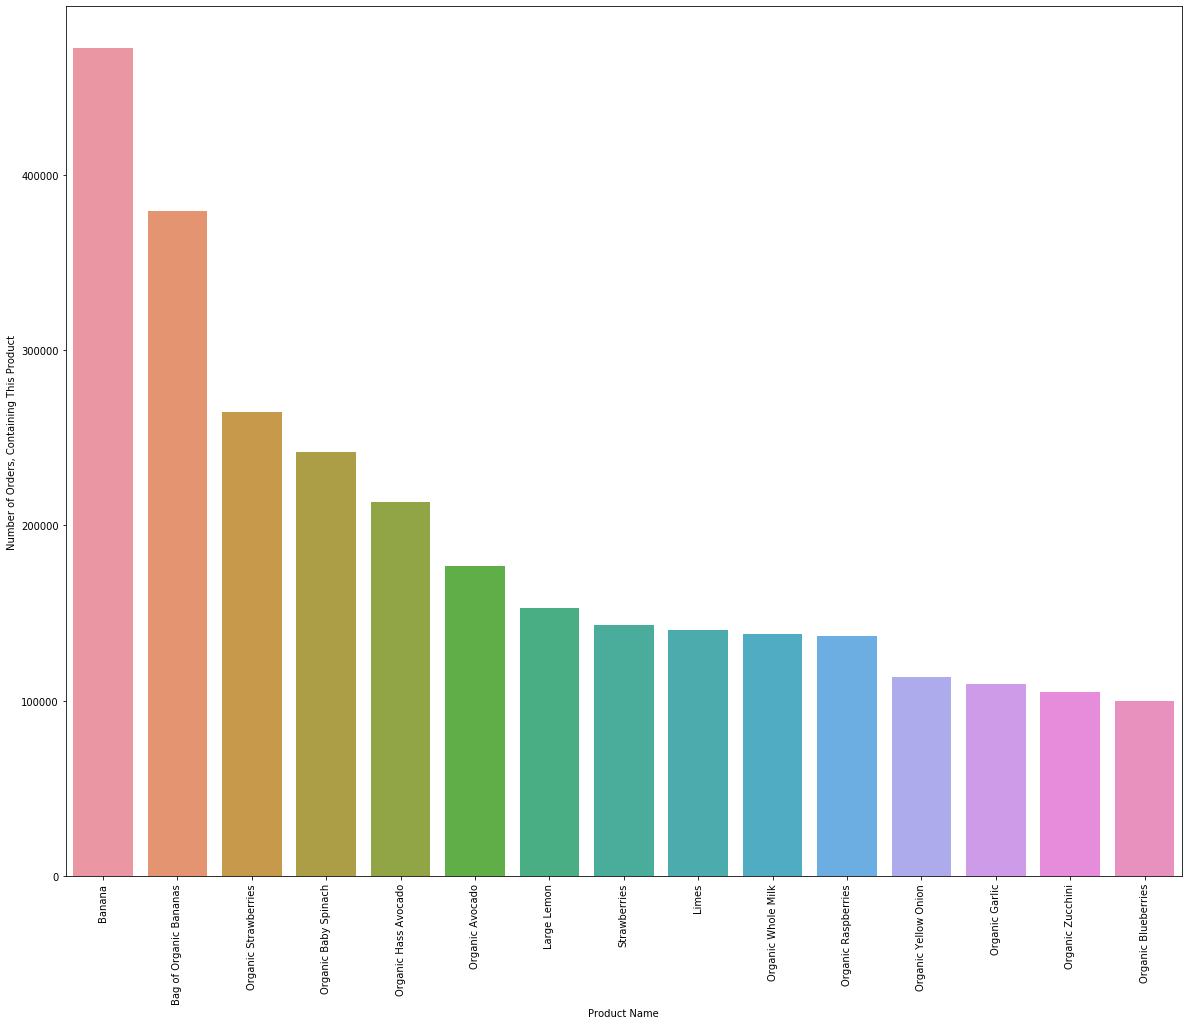

In [23]:
top_products = pd.merge(
    left=pd.DataFrame(full_data.groupby(['product_id'])['order_id']\
    .apply(lambda x: len(x.unique())).sort_values(ascending=False)[:15].reset_index('product_id')),
    right=pd.merge(left=pd.merge(left=products, right=departments, how='left'), right=aisles, how='left'),
    how='left')

f, ax = plt.subplots(figsize=(20, 16))
plt.xticks(rotation='vertical')
sns.barplot(top_products.product_name, top_products.order_id)
plt.ylabel('Number of Orders, Containing This Product')
plt.xlabel('Product Name')

**Bananas, both organic and not, were bought signicantly more than most other products**

### What products were most reordered?

**To determine this, we're going to take the probability of each item to be reordered.**

In [24]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0, sort=False)
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,'reorder_total': 'count'}).reset_index()
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped[grouped.reorder_total > 75].sort_values(['reorder_probability'], ascending=False)[:10]
grouped

C:\Users\steph\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,product_id,reorder_sum,reorder_total,reorder_probability,product_name
2074,2075,84,90,0.933333,Serenity Ultimate Extrema Overnight Pads
27737,27740,94,102,0.921569,Chocolate Love Bar
35601,35604,93,104,0.894231,Maca Buttercups
38248,38251,99,111,0.891892,Benchbreak Chardonnay
36798,36801,88,99,0.888889,Organic Blueberry B Mega
10233,10236,114,131,0.870229,Fragrance Free Clay with Natural Odor Eliminat...
20595,20598,99,114,0.868421,Thousand Island Salad Snax
5455,5457,78,90,0.866667,Classic Carbonated Natural Mineral Water
35493,35496,394,457,0.862144,Real2 Alkalized Water 500 ml
9289,9292,2580,2995,0.861436,Half And Half Ultra Pasteurized


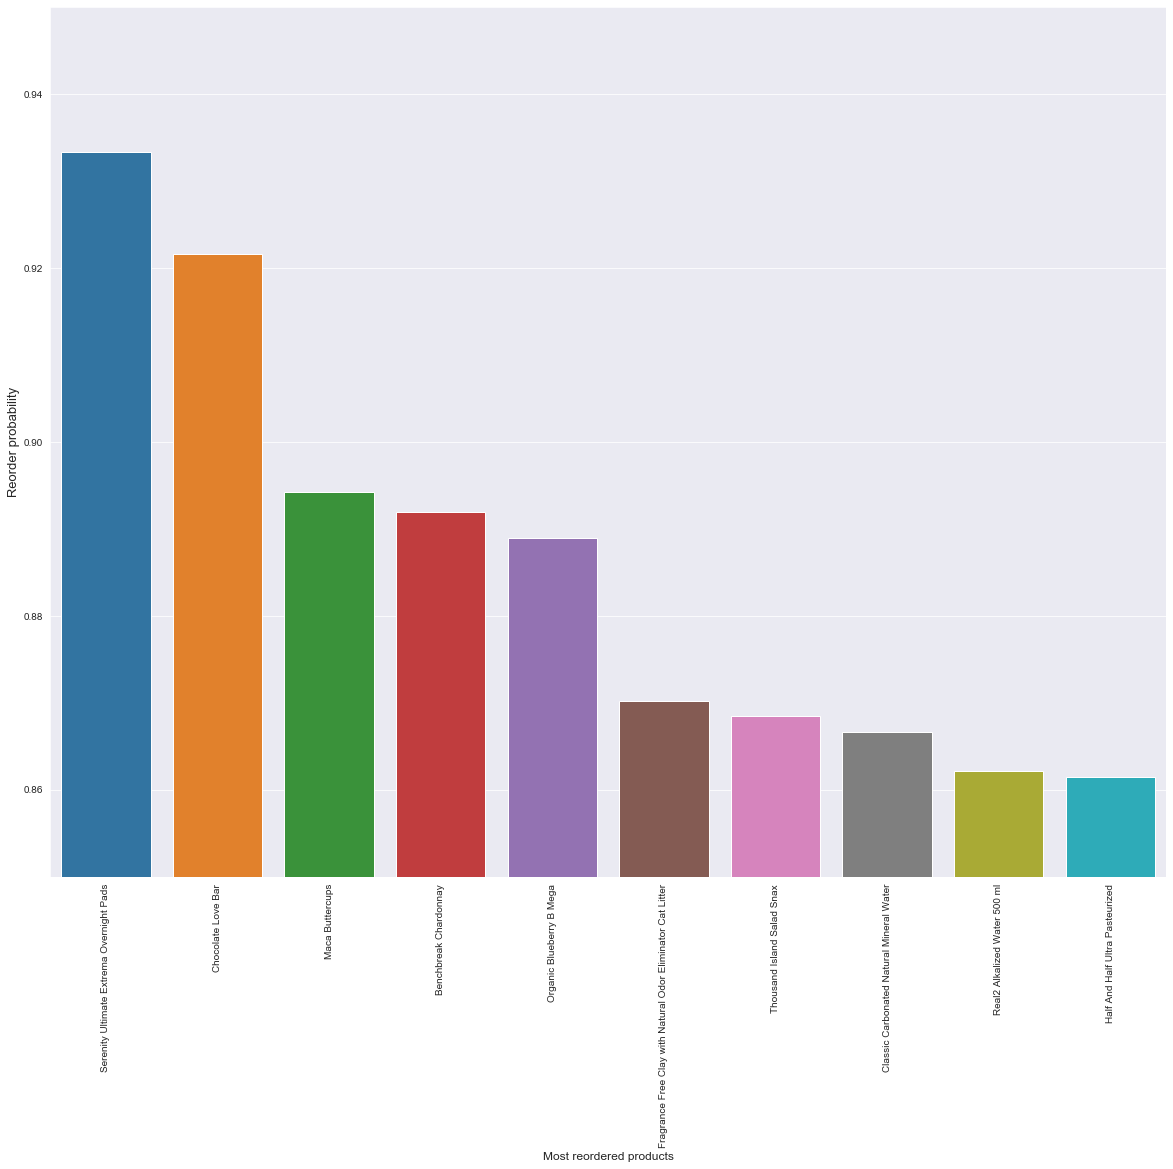

In [25]:
grouped  = grouped.groupby(['product_name']).sum()['reorder_probability'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(20, 16))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylim([0.85,0.95])
plt.ylabel('Reorder probability', fontsize=13)
plt.xlabel('Most reordered products', fontsize=12)
plt.show()

**Most reordered items were overnight pads, candy, and wine.**

### What is the distribution of departments?

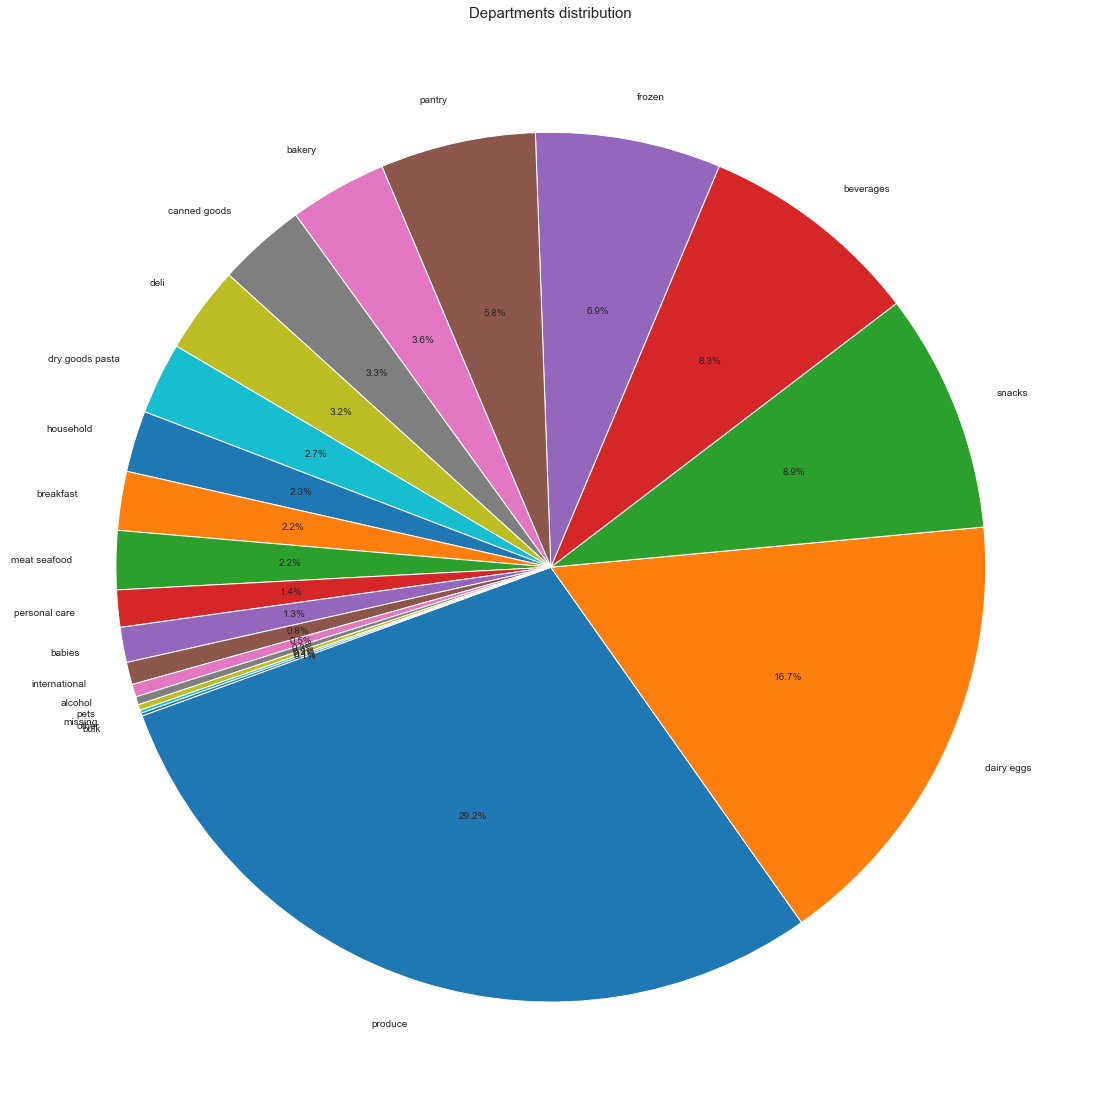

In [26]:
plt.figure(figsize=(20,20))
temp_series = order_products_prior['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

**Produce is the largest aisle**

### What aisles are the most important?

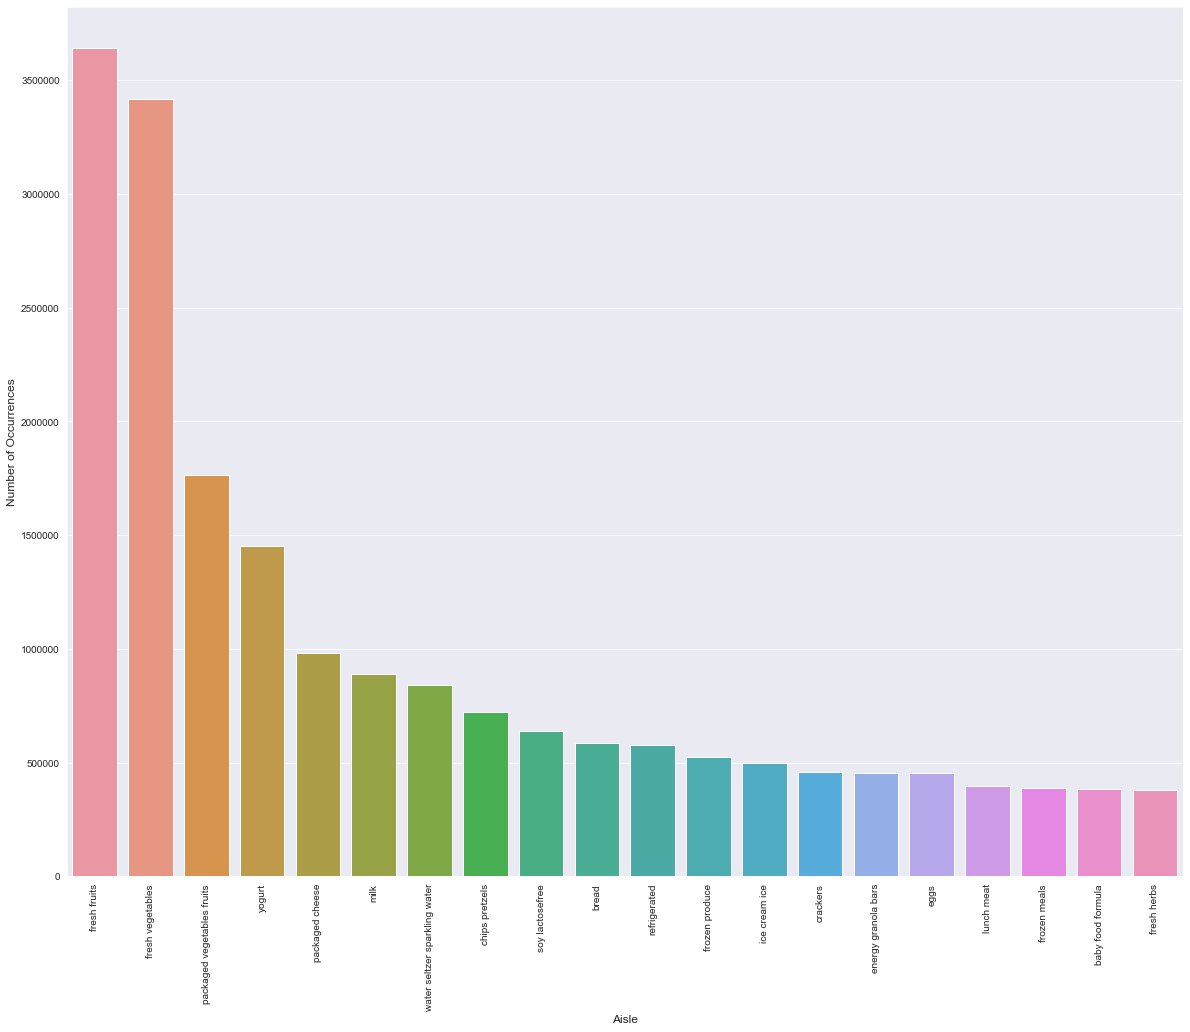

In [27]:
count_df = order_products_prior['aisle'].value_counts().head(20)
plt.figure(figsize=(20,16))
sns.barplot(count_df.index, count_df.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

**Top two aisles are fresh fruits and fresh vegetables**

### Let's break down each department by aisle to find most important aisles. 

C:\Users\steph\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


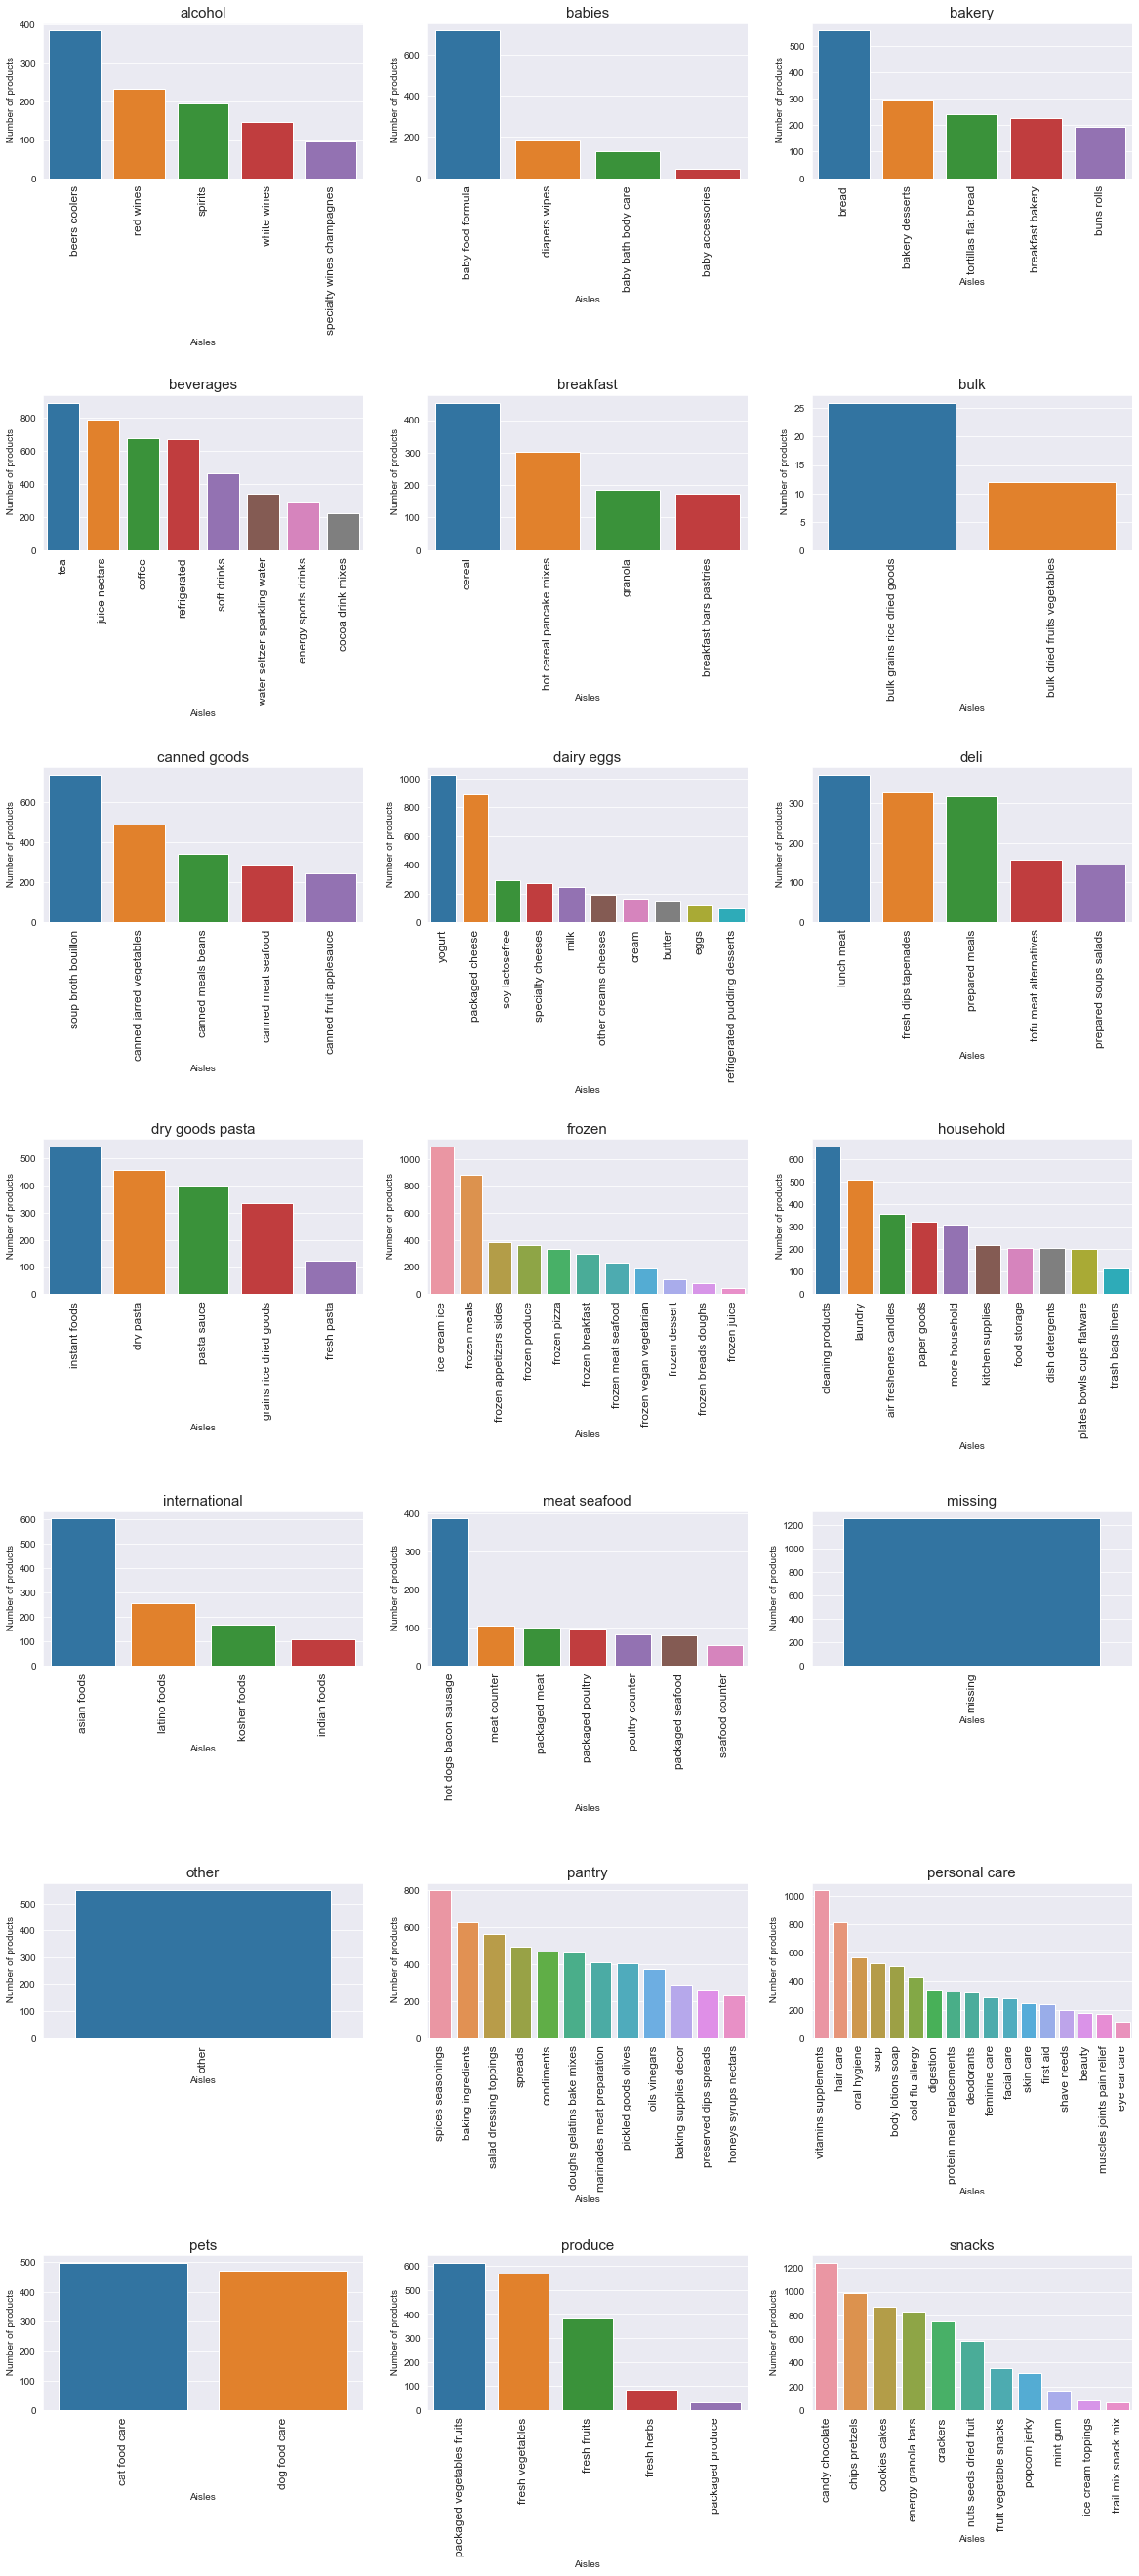

In [28]:
items  = pd.merge(left =pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
grouped = items.groupby(["department", "aisle"])["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_products , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

### Now we can look at the relationship between how order of adding the product to the cart affects the reorder ratio.

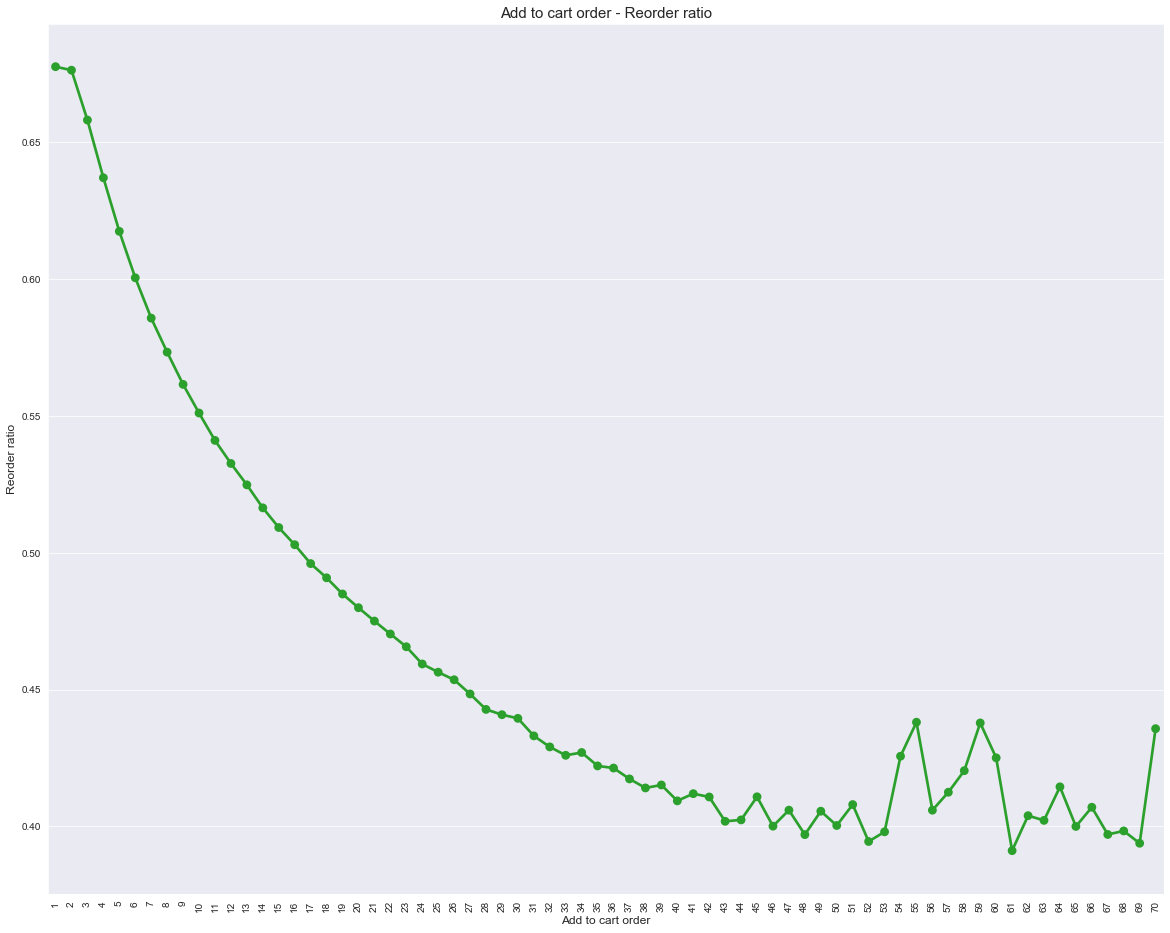

In [29]:
order_products_prior["add_to_cart_order_mod"] = order_products_prior["add_to_cart_order"].copy()
order_products_prior["add_to_cart_order_mod"].loc[order_products_prior["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(20,16))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

**Looks like the products that are added to the cart initially are more likely to be reordered again compared to the ones added later.**

### Reorder ratio by time-based variables

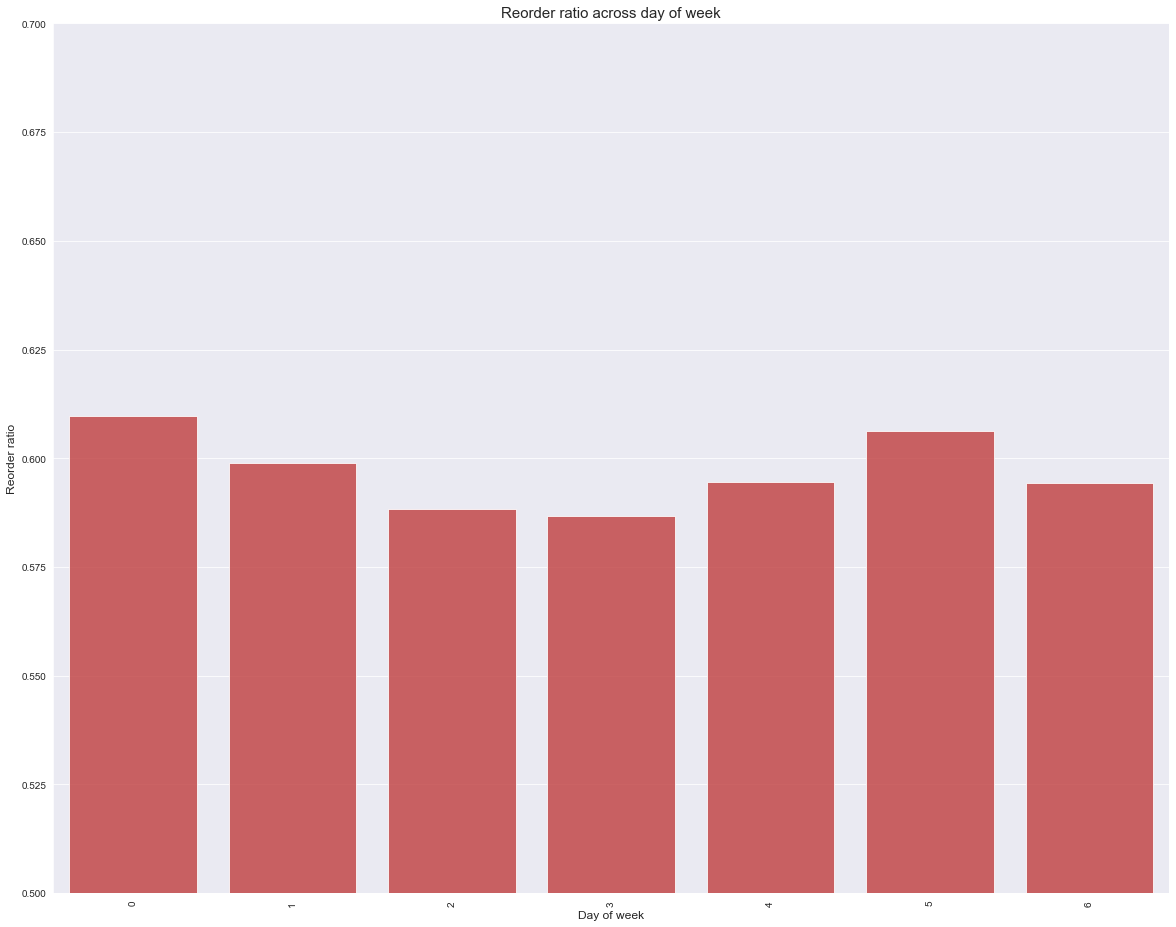

In [30]:
order_products_train = pd.merge(order_products_train, orders, on='order_id', how='left')
grouped_df = order_products_train.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(20,16))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

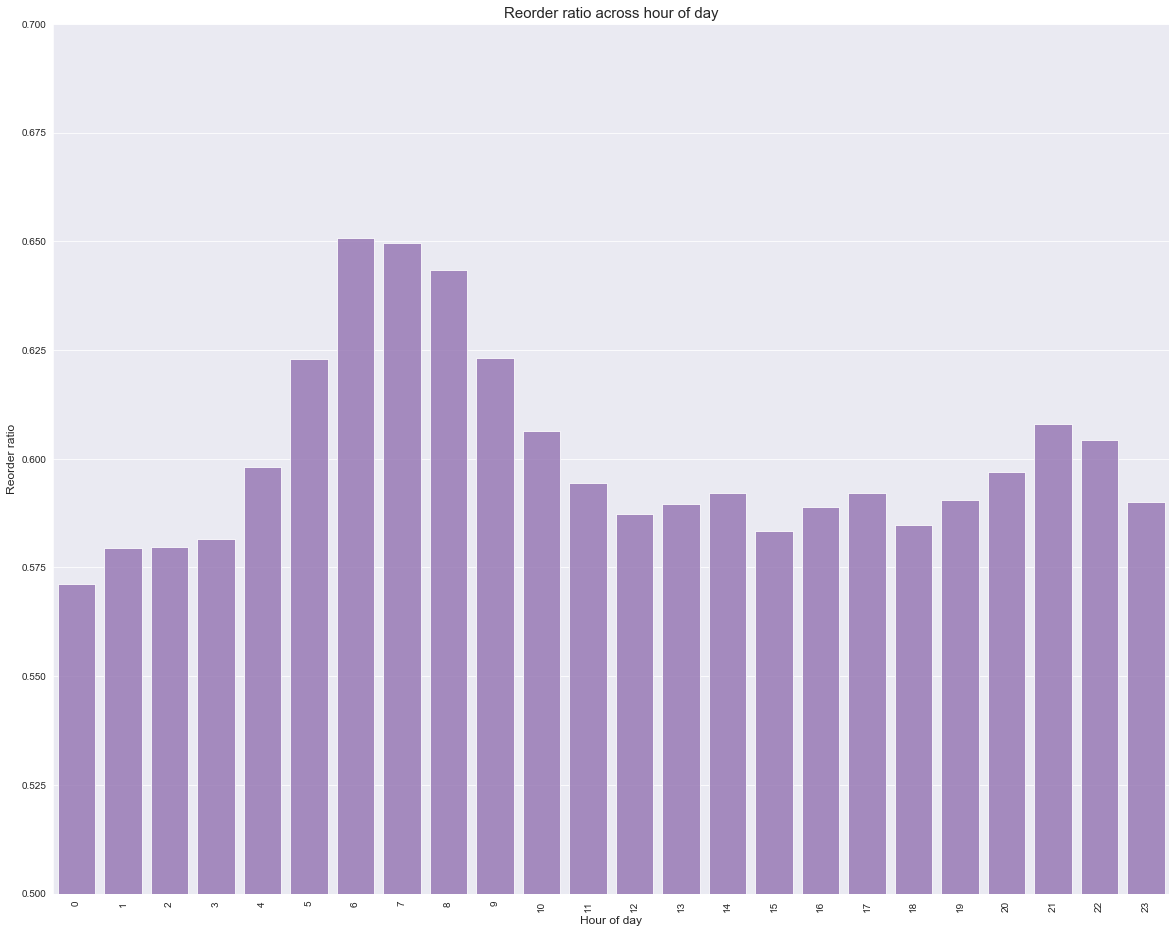

In [31]:
grouped_df = order_products_train.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(20,16))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

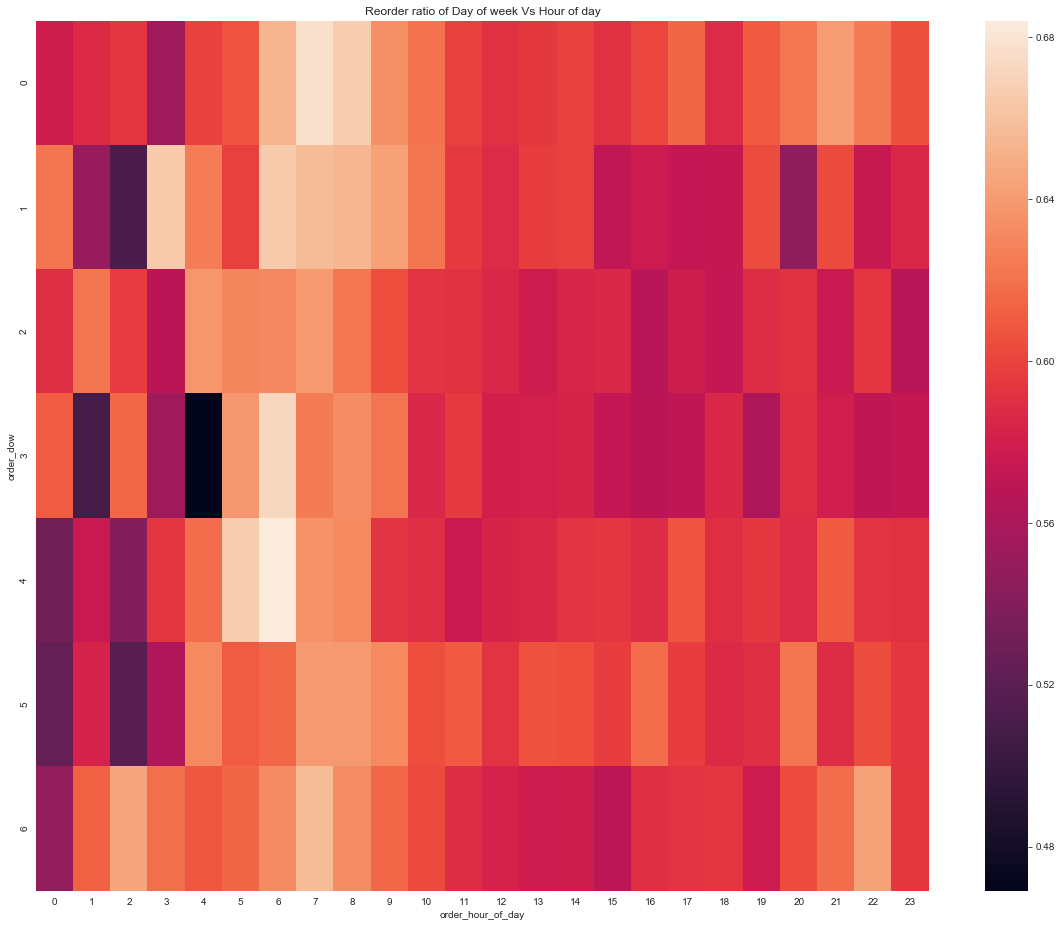

In [32]:
grouped_df = order_products_train.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(20,16))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

**Looks like reorder ratios are quite high during the early mornings compared to later half of the day.**

In [33]:
train = order_products_train
prior = order_products_prior

In [34]:
train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,train,4,4,10,9.0
1,1,11109,2,1,112108,train,4,4,10,9.0
2,1,10246,3,0,112108,train,4,4,10,9.0
3,1,49683,4,0,112108,train,4,4,10,9.0
4,1,43633,5,1,112108,train,4,4,10,9.0


In [35]:
np.sqrt(metrics.mean_squared_error(train.price, train.prediction))

AttributeError: 'DataFrame' object has no attribute 'price'